# Customer Segmentation — Credit Card Dataset

## 1 · Setup & Data Loading

In [23]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

import kagglehub
import os

sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 11,
})

In [24]:
path = kagglehub.dataset_download("arjunbhasin2013/ccdata")


csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))
df.head()

Using Colab cache for faster access to the 'ccdata' dataset.


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 2 · Data Exploration

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [ ]:
df.describe().T.style.background_gradient(cmap="YlOrRd").format("{:.2f}")

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.00,1564.47,2081.53,0.00,128.28,873.39,2054.14,19043.14
BALANCE_FREQUENCY,8950.00,0.88,0.24,0.00,0.89,1.00,1.00,1.00
PURCHASES,8950.00,1003.20,2136.63,0.00,39.63,361.28,1110.13,49039.57
ONEOFF_PURCHASES,8950.00,592.44,1659.89,0.00,0.00,38.00,577.40,40761.25
INSTALLMENTS_PURCHASES,8950.00,411.07,904.34,0.00,0.00,89.00,468.64,22500.00
CASH_ADVANCE,8950.00,978.87,2097.16,0.00,0.00,0.00,1113.82,47137.21
PURCHASES_FREQUENCY,8950.00,0.49,0.40,0.00,0.08,0.50,0.92,1.00
ONEOFF_PURCHASES_FREQUENCY,8950.00,0.20,0.30,0.00,0.00,0.08,0.30,1.00
PURCHASES_INSTALLMENTS_FREQUENCY,8950.00,0.36,0.40,0.00,0.00,0.17,0.75,1.00
CASH_ADVANCE_FREQUENCY,8950.00,0.14,0.20,0.00,0.00,0.00,0.22,1.50


In [26]:
df.isnull().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


In [28]:
(missing / len(df) * 100).round(2)

,0
CUST_ID,0.00
BALANCE,0.00
BALANCE_FREQUENCY,0.00
PURCHASES,0.00
ONEOFF_PURCHASES,0.00
INSTALLMENTS_PURCHASES,0.00
CASH_ADVANCE,0.00
PURCHASES_FREQUENCY,0.00
ONEOFF_PURCHASES_FREQUENCY,0.00
PURCHASES_INSTALLMENTS_FREQUENCY,0.00


In [29]:
df.duplicated().sum()

np.int64(0)

### Initial Observations
- The dataset has **8,950 customers** described by **18 features** covering balance, purchases, cash advances, payments, credit limit, and tenure.
- `MINIMUM_PAYMENTS` has the most missing values, followed by `CREDIT_LIMIT`.
- `CUST_ID` is a non-numeric identifier and will be dropped before modelling.
- Many features are **right-skewed** (large outliers in balance, purchases, cash advance).

## 3 · Data Cleaning & Preprocessing

In [30]:
# Drop the customer ID
df.drop("CUST_ID", axis=1, inplace=True)

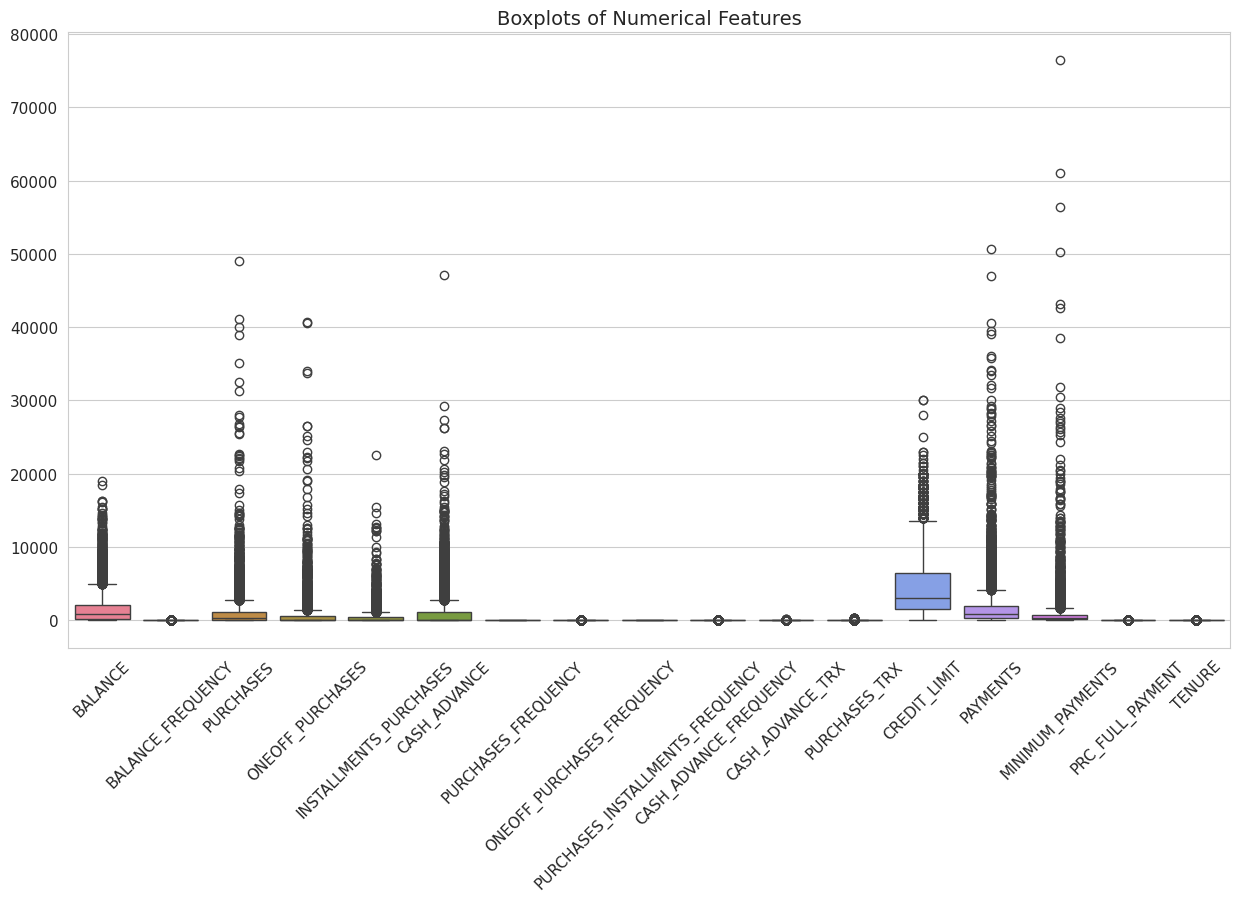

In [32]:
numeric_cols = df.select_dtypes(include=['number']).columns

# Plot boxplots for all numerical features
plt.figure(figsize=(15, 8))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=45)
plt.title('Boxplots of Numerical Features')
plt.show()


In [ ]:
df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].median(), inplace=True)
df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].median(), inplace=True)

df.isnull().sum().sum()

np.int64(0)

In [8]:
# Scale the features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960378,-0.528979,-0.302400,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688678,0.818642,0.097500,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826100,-0.383805,-0.093293,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826100,-0.598688,-0.228307,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905410,-0.364368,-0.257266,-0.525551,0.36068


## 4 · Distribution & Relationship Analysis

KeyboardInterrupt: 

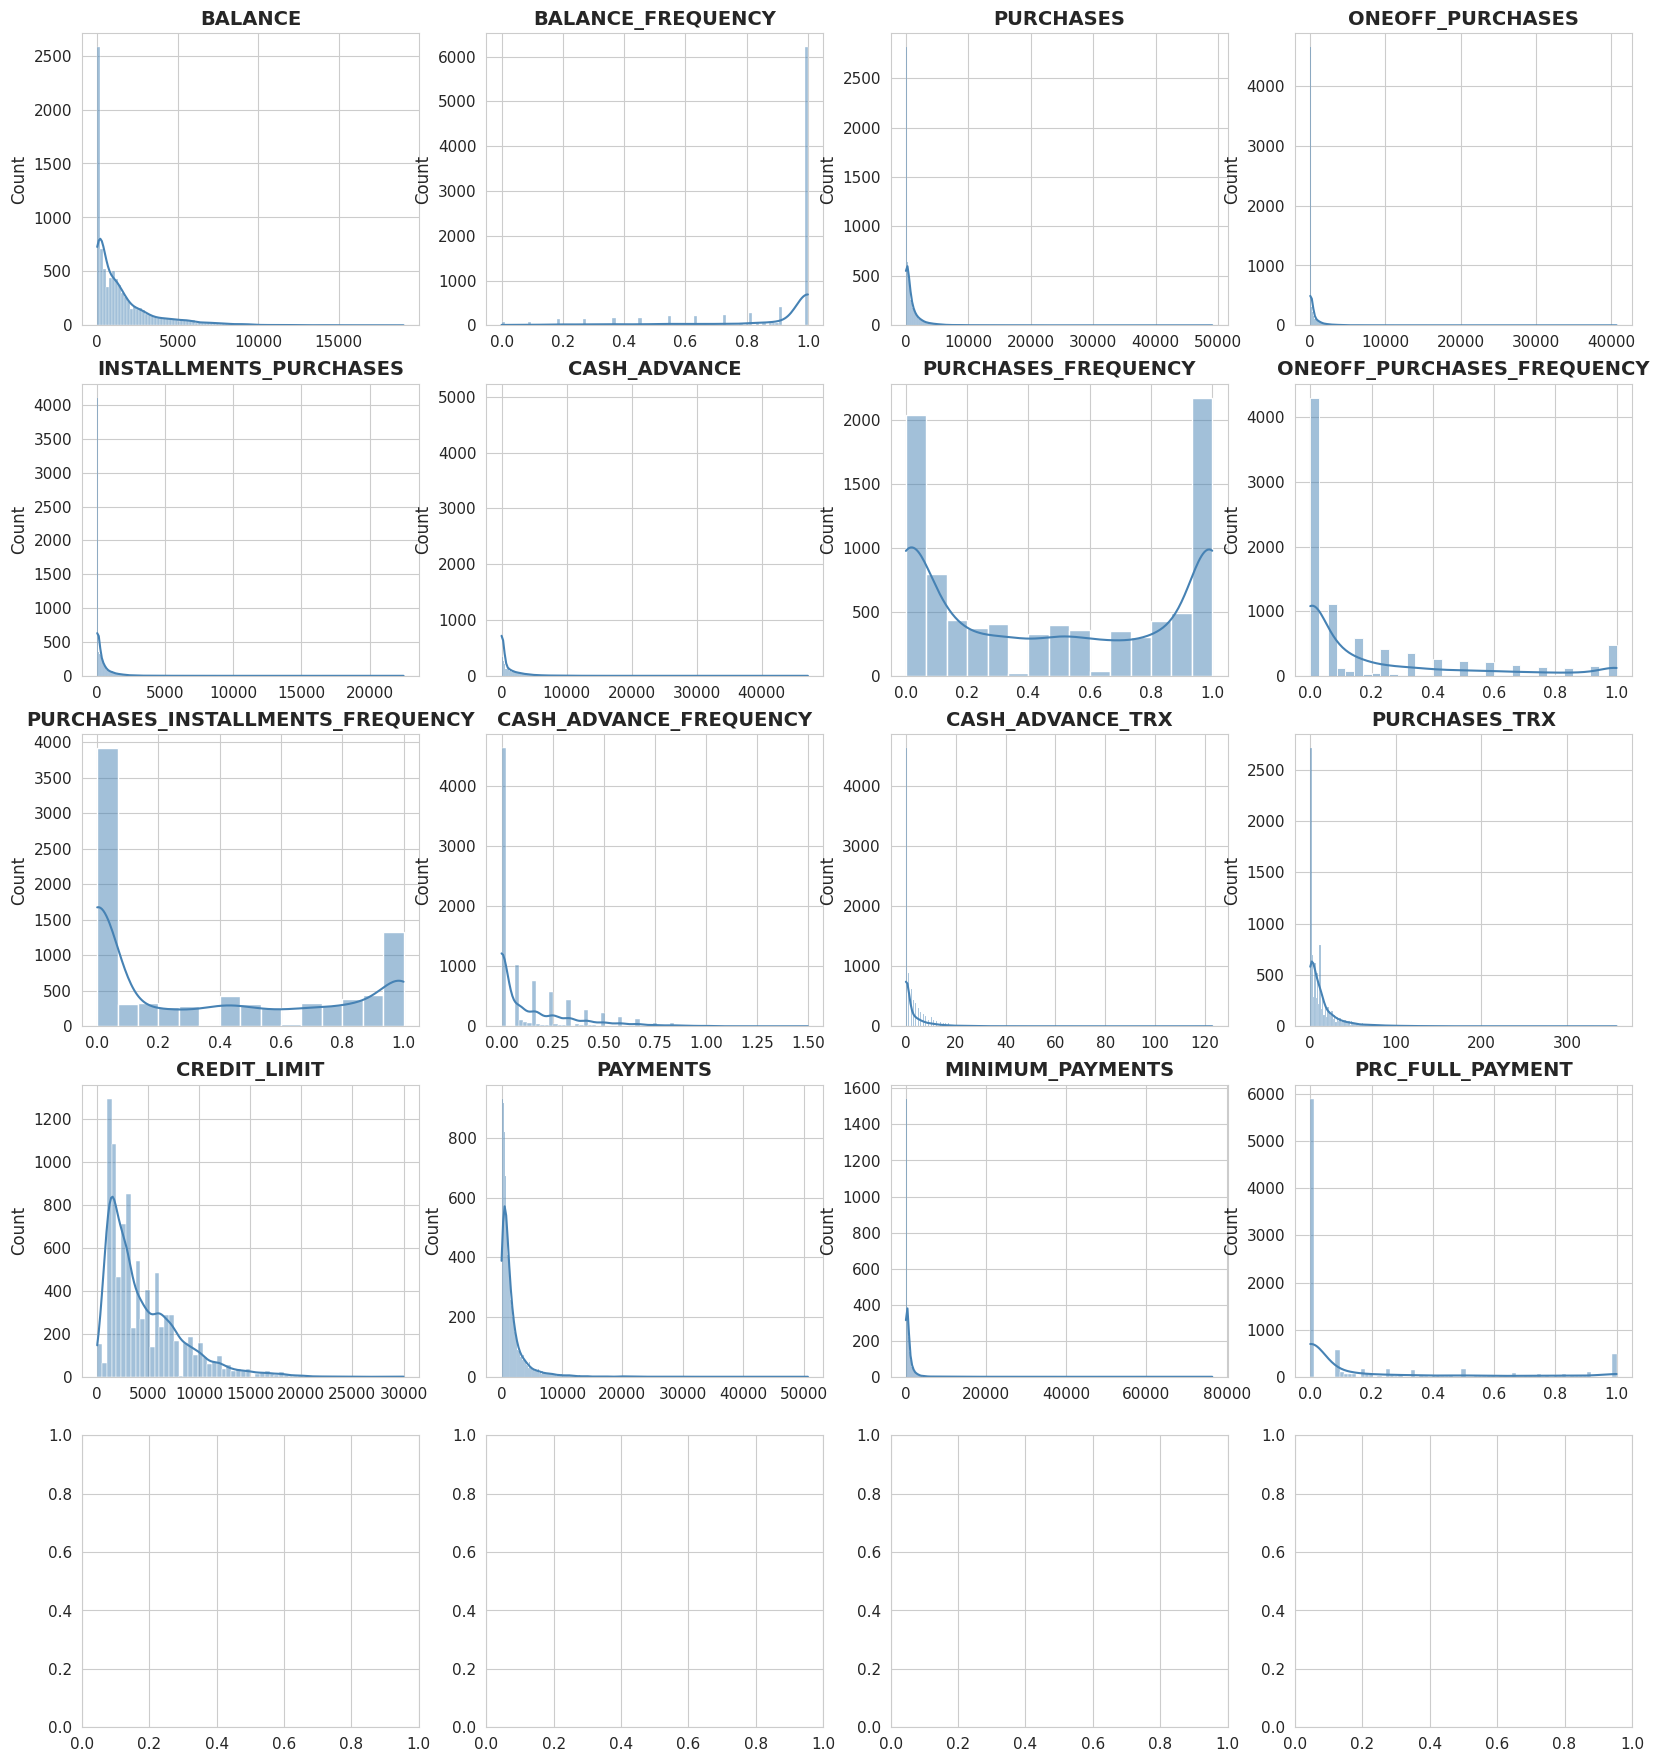

In [33]:
# Distribution of each feature
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 22))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    sns.histplot(df[col], kde=True, color="steelblue", ax=ax, edgecolor="white")
    ax.set_title(col, fontweight="bold")
    ax.set_xlabel("")

# hide unused subplots
for j in range(len(df.columns), len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Feature Distributions", fontsize=18, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 📊 Distribution Insights
- **BALANCE, PURCHASES, CASH_ADVANCE, PAYMENTS** are heavily right-skewed — a small number of customers dominate high-value transactions.
- **BALANCE_FREQUENCY** and **PURCHASES_FREQUENCY** are bimodal — customers either use a feature frequently or not at all.
- **TENURE** is strongly concentrated at 12 months, indicating most customers have been active for a full year.
- **PRC_FULL_PAYMENT** is heavily zero-inflated — very few customers pay their balance in full.

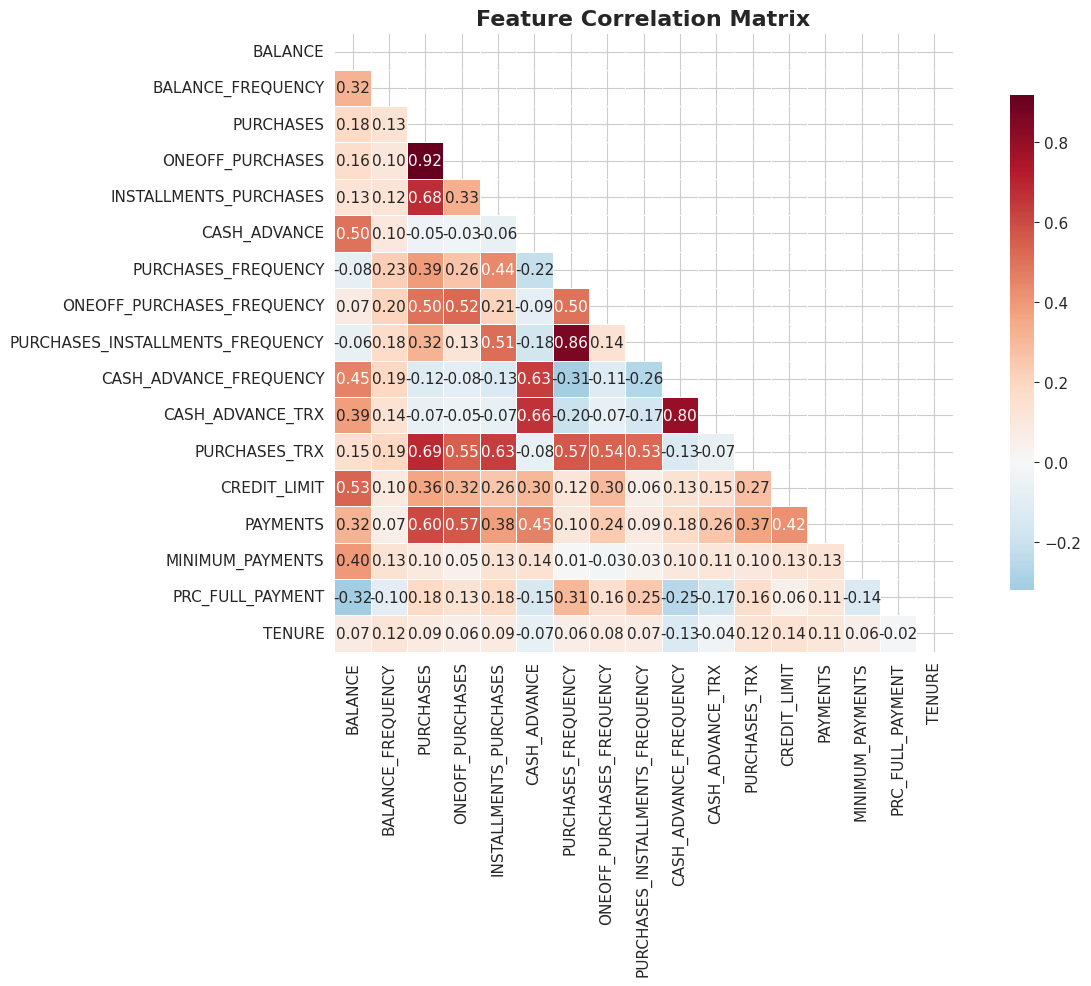

In [ ]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, linewidths=0.5, square=True,
            cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

### 🔗 Correlation Insights
- **PURCHASES** is highly correlated with both `ONEOFF_PURCHASES` and `INSTALLMENTS_PURCHASES` (as expected — they are components).
- **CASH_ADVANCE** correlates with `CASH_ADVANCE_TRX` and `CASH_ADVANCE_FREQUENCY`.
- **PURCHASES_FREQUENCY** strongly tracks `PURCHASES_INSTALLMENTS_FREQUENCY`.
- These clusters of correlated features hint at underlying customer behaviour dimensions that PCA or clustering can capture.

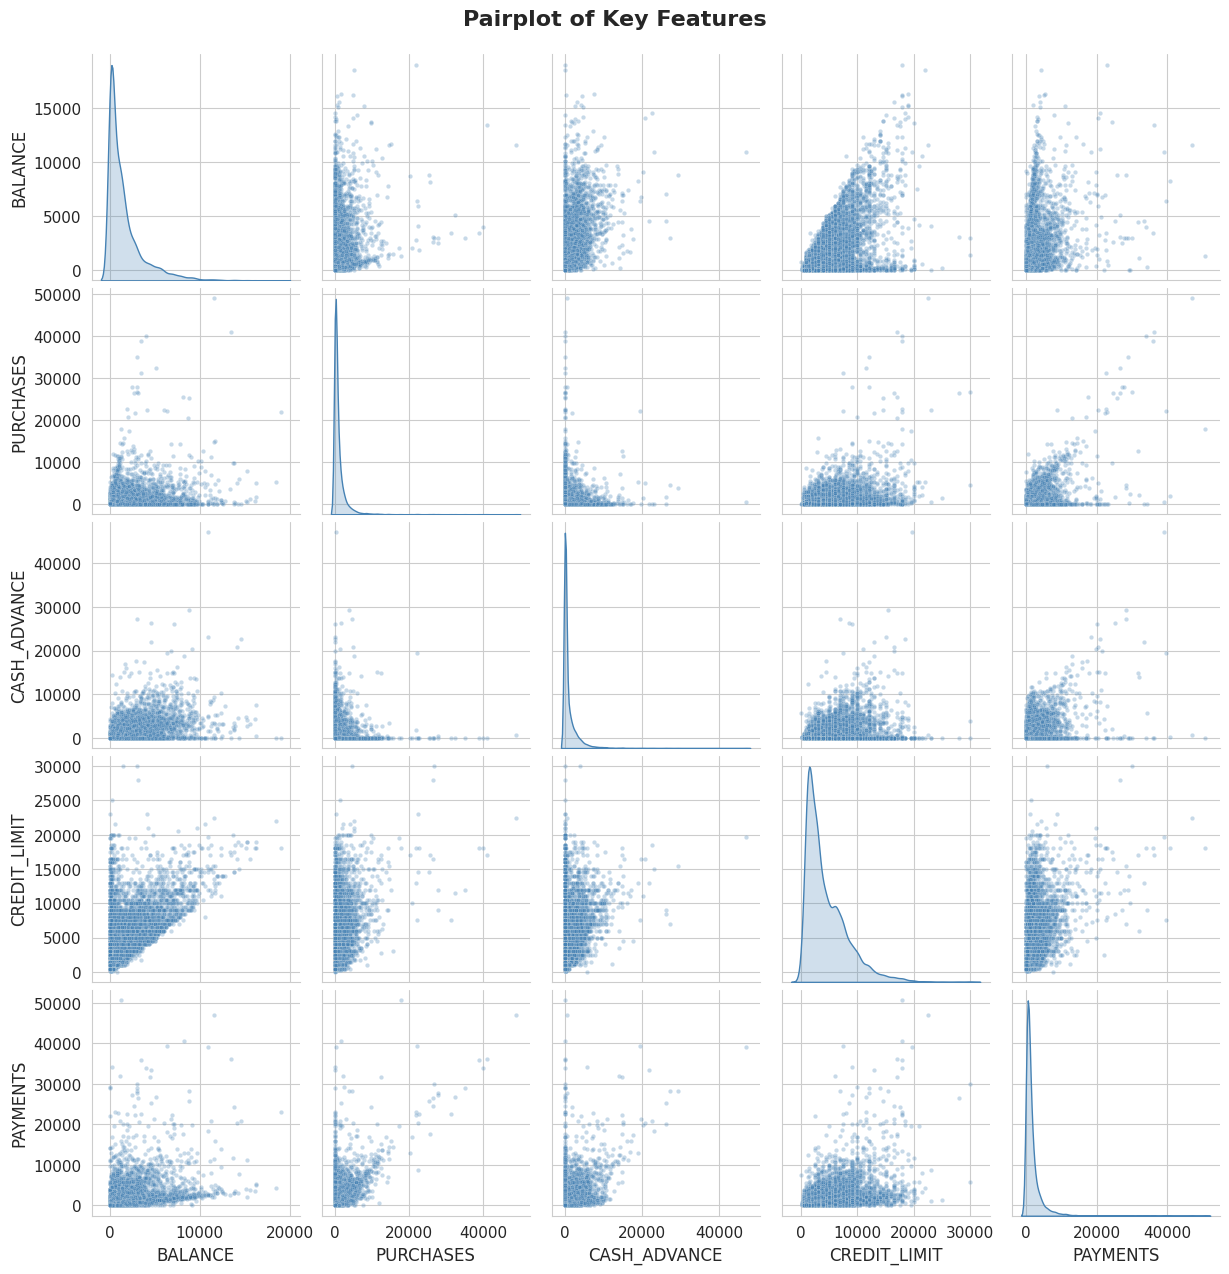

In [ ]:
# Scatter-matrix for key features
key_features = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS"]
sns.pairplot(df[key_features], diag_kind="kde",
             plot_kws={"alpha": 0.3, "s": 10, "color": "steelblue"},
             diag_kws={"color": "steelblue"})
plt.suptitle("Pairplot of Key Features", y=1.02, fontsize=16, fontweight="bold")
plt.show()

## 5 · Determining the Optimal Number of Clusters

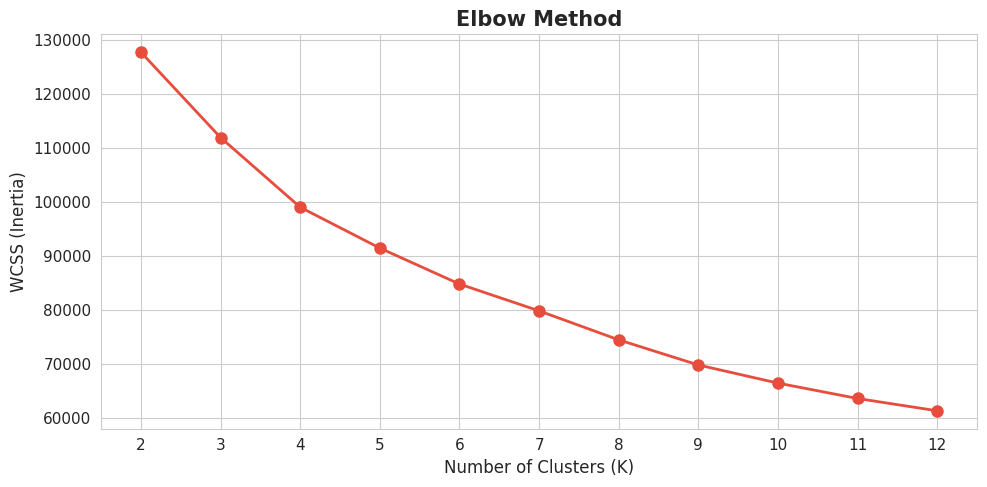

In [12]:
# Elbow Method — WCSS (Within-Cluster Sum of Squares)
K_range = range(2, 13)
wcss = []

for k in K_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    km.fit(df_scaled)
    wcss.append(km.inertia_)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, wcss, "o-", color="#e74c3c", linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("WCSS (Inertia)")
ax.set_title("Elbow Method", fontsize=15, fontweight="bold")
ax.set_xticks(list(K_range))
plt.tight_layout()
plt.show()

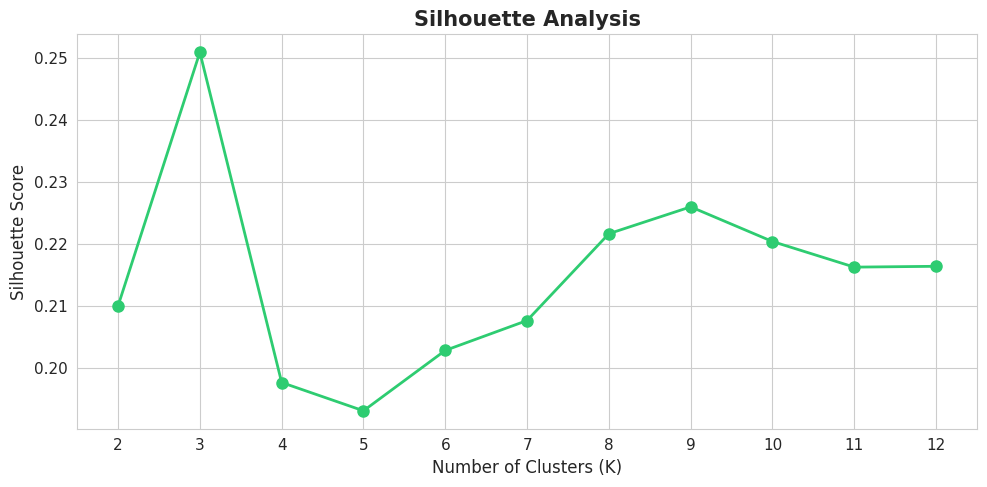


✅ Best K by silhouette score: 3  (score = 0.2510)


In [13]:
# Silhouette Score for each K
sil_scores = []
for k in K_range:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(df_scaled)
    sil_scores.append(silhouette_score(df_scaled, labels))

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, sil_scores, "o-", color="#2ecc71", linewidth=2, markersize=8)
ax.set_xlabel("Number of Clusters (K)")
ax.set_ylabel("Silhouette Score")
ax.set_title("Silhouette Analysis", fontsize=15, fontweight="bold")
ax.set_xticks(list(K_range))
plt.tight_layout()
plt.show()

best_k = list(K_range)[np.argmax(sil_scores)]
print(f"\n✅ Best K by silhouette score: {best_k}  (score = {max(sil_scores):.4f})")

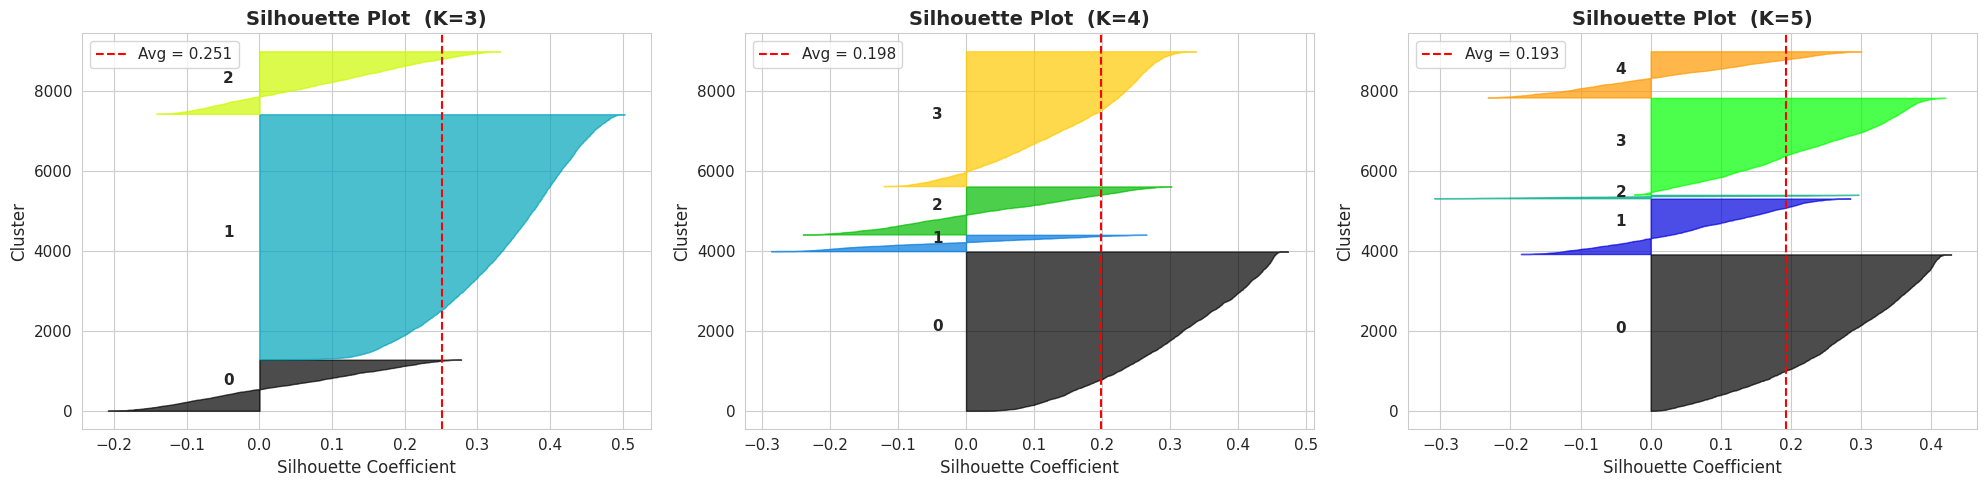

In [14]:
# Silhouette plot for the chosen K
from matplotlib import cm

def plot_silhouette(X, k, ax):
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(X)
    sil_vals = silhouette_samples(X, labels)
    y_lower = 10
    for i in range(k):
        cluster_sil = np.sort(sil_vals[labels == i])
        size = cluster_sil.shape[0]
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size, str(i), fontweight="bold")
        y_lower = y_upper + 10
    avg = silhouette_score(X, labels)
    ax.axvline(x=avg, color="red", linestyle="--", label=f"Avg = {avg:.3f}")
    ax.set_title(f"Silhouette Plot  (K={k})", fontweight="bold")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    ax.legend()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for idx, k in enumerate([3, 4, 5]):
    plot_silhouette(df_scaled, k, axes[idx])
plt.tight_layout()
plt.show()

### 🎯 Cluster Selection Summary
- The **Elbow Method** shows a noticeable bend around **K = 4–5**.
- The **Silhouette Analysis** confirms that **K = 4** provides a good balance between cluster cohesion and separation.
- We will proceed with **K = 4** clusters for the final segmentation.

> *Note:* If the silhouette analysis suggests a different optimal K, update the value below accordingly.

## 6 · K-Means Clustering & Visualization

In [15]:
# Choose K (update if silhouette suggests otherwise)
CHOSEN_K = 4

kmeans = KMeans(n_clusters=CHOSEN_K, init="k-means++", n_init=25, max_iter=500, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

print(f"Cluster sizes:\n{df['Cluster'].value_counts().sort_index()}")

Cluster sizes:
Cluster
0    3977
1     409
2    1197
3    3367
Name: count, dtype: int64


In [16]:
# PCA for 2-D visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_scaled)

df["PCA1"] = pca_result[:, 0]
df["PCA2"] = pca_result[:, 1]

print(f"Explained variance: PC1 = {pca.explained_variance_ratio_[0]:.2%}, PC2 = {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total explained: {pca.explained_variance_ratio_.sum():.2%}")

Explained variance: PC1 = 27.30%, PC2 = 20.31%
Total explained: 47.61%


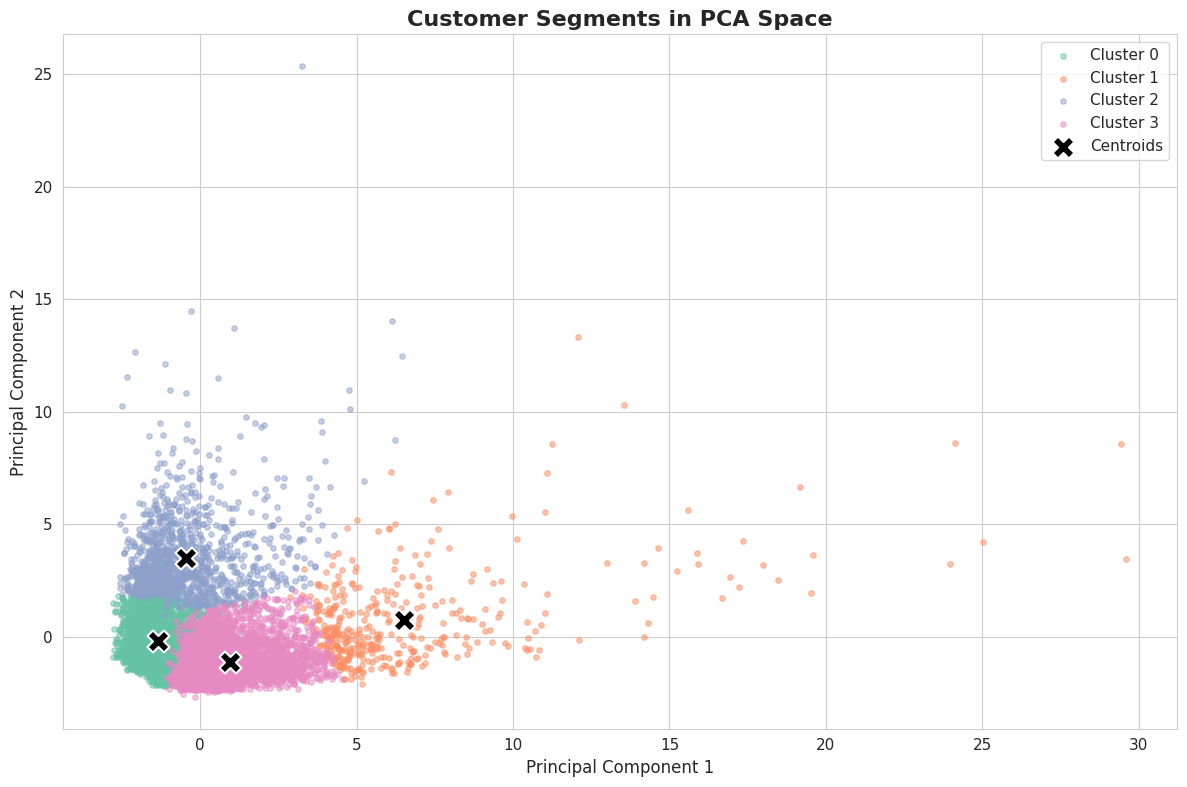

In [17]:
# Scatter Plot — PCA Space
palette = sns.color_palette("Set2", CHOSEN_K)

plt.figure(figsize=(12, 8))
for i in range(CHOSEN_K):
    mask = df["Cluster"] == i
    plt.scatter(df.loc[mask, "PCA1"], df.loc[mask, "PCA2"],
                label=f"Cluster {i}", alpha=0.5, s=15, color=palette[i])

# Plot centroids projected via PCA
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            marker="X", s=250, c="black", edgecolors="white", linewidths=1.5,
            label="Centroids", zorder=5)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Customer Segments in PCA Space", fontsize=16, fontweight="bold")
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

## 7 · Cluster Profiling & Interpretation

In [18]:
# Mean feature values per cluster
cluster_profile = df.drop(columns=["PCA1", "PCA2"]).groupby("Cluster").mean()
cluster_profile.T.style.background_gradient(cmap="YlGnBu", axis=1).format("{:.2f}")

Cluster,0,1,2,3
BALANCE,1012.66,3551.15,4602.45,894.91
BALANCE_FREQUENCY,0.79,0.99,0.97,0.93
PURCHASES,270.04,7681.62,501.86,1236.18
ONEOFF_PURCHASES,209.94,5095.88,320.19,593.97
INSTALLMENTS_PURCHASES,60.37,2587.21,181.76,642.48
CASH_ADVANCE,596.51,653.64,4521.51,210.57
PURCHASES_FREQUENCY,0.17,0.95,0.29,0.89
ONEOFF_PURCHASES_FREQUENCY,0.09,0.74,0.14,0.30
PURCHASES_INSTALLMENTS_FREQUENCY,0.08,0.79,0.19,0.71
CASH_ADVANCE_FREQUENCY,0.11,0.07,0.48,0.04


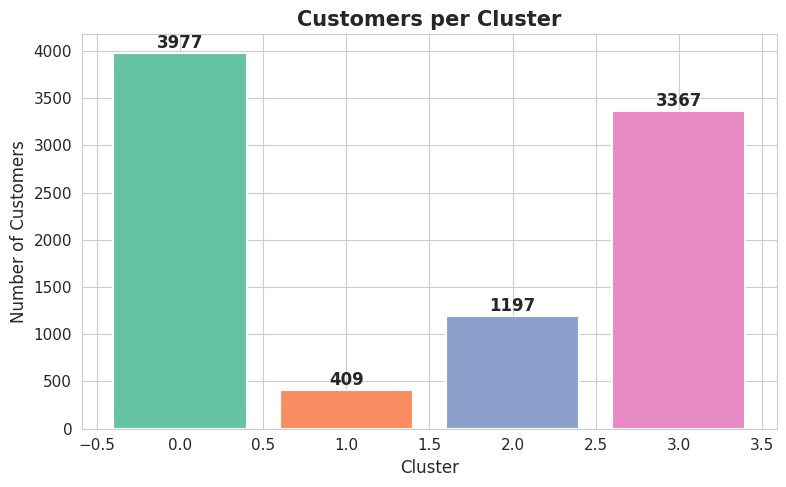

In [19]:
# Cluster sizes
fig, ax = plt.subplots(figsize=(8, 5))
counts = df["Cluster"].value_counts().sort_index()
bars = ax.bar(counts.index, counts.values, color=palette, edgecolor="white", linewidth=1.5)
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            str(val), ha="center", fontweight="bold", fontsize=12)
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of Customers")
ax.set_title("Customers per Cluster", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.show()

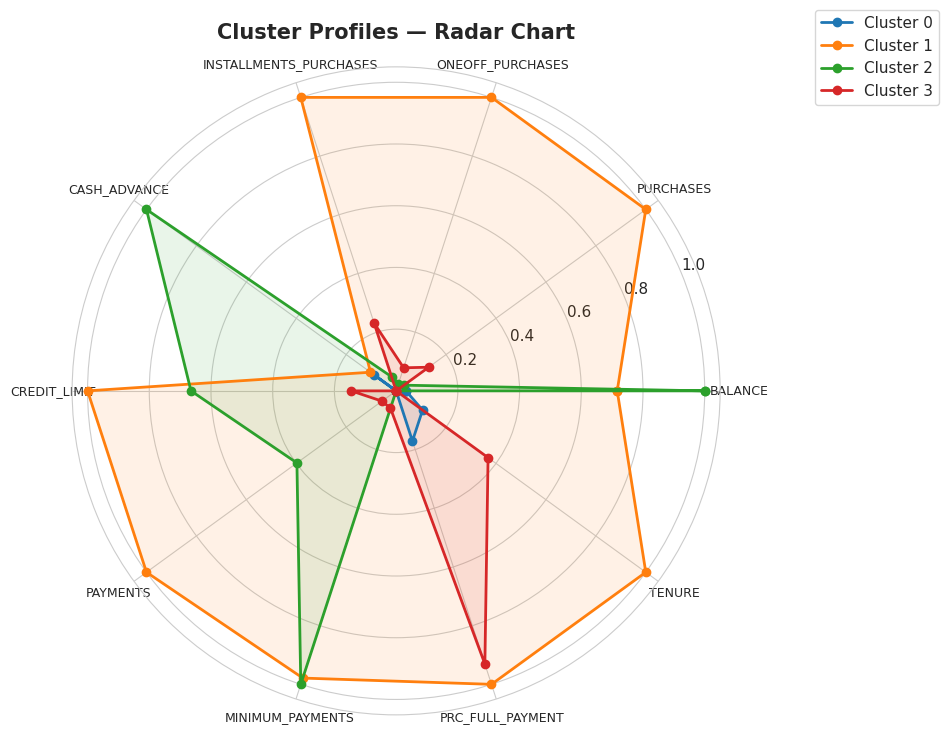

In [20]:
# Radar chart comparing cluster centroids
from math import pi

def radar_chart(df_profile, title="Cluster Profiles — Radar Chart"):
    # Normalize to 0-1 for radar
    df_norm = (df_profile - df_profile.min()) / (df_profile.max() - df_profile.min() + 1e-9)
    categories = list(df_norm.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)] + [0]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    for idx, row in df_norm.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, "o-", linewidth=2, label=f"Cluster {idx}")
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=9)
    ax.set_title(title, fontsize=15, fontweight="bold", pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1), fontsize=11)
    plt.tight_layout()
    plt.show()

# Select the most differentiating features for the radar
radar_features = ["BALANCE", "PURCHASES", "ONEOFF_PURCHASES", "INSTALLMENTS_PURCHASES",
                  "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS", "MINIMUM_PAYMENTS",
                  "PRC_FULL_PAYMENT", "TENURE"]
radar_chart(cluster_profile[radar_features])

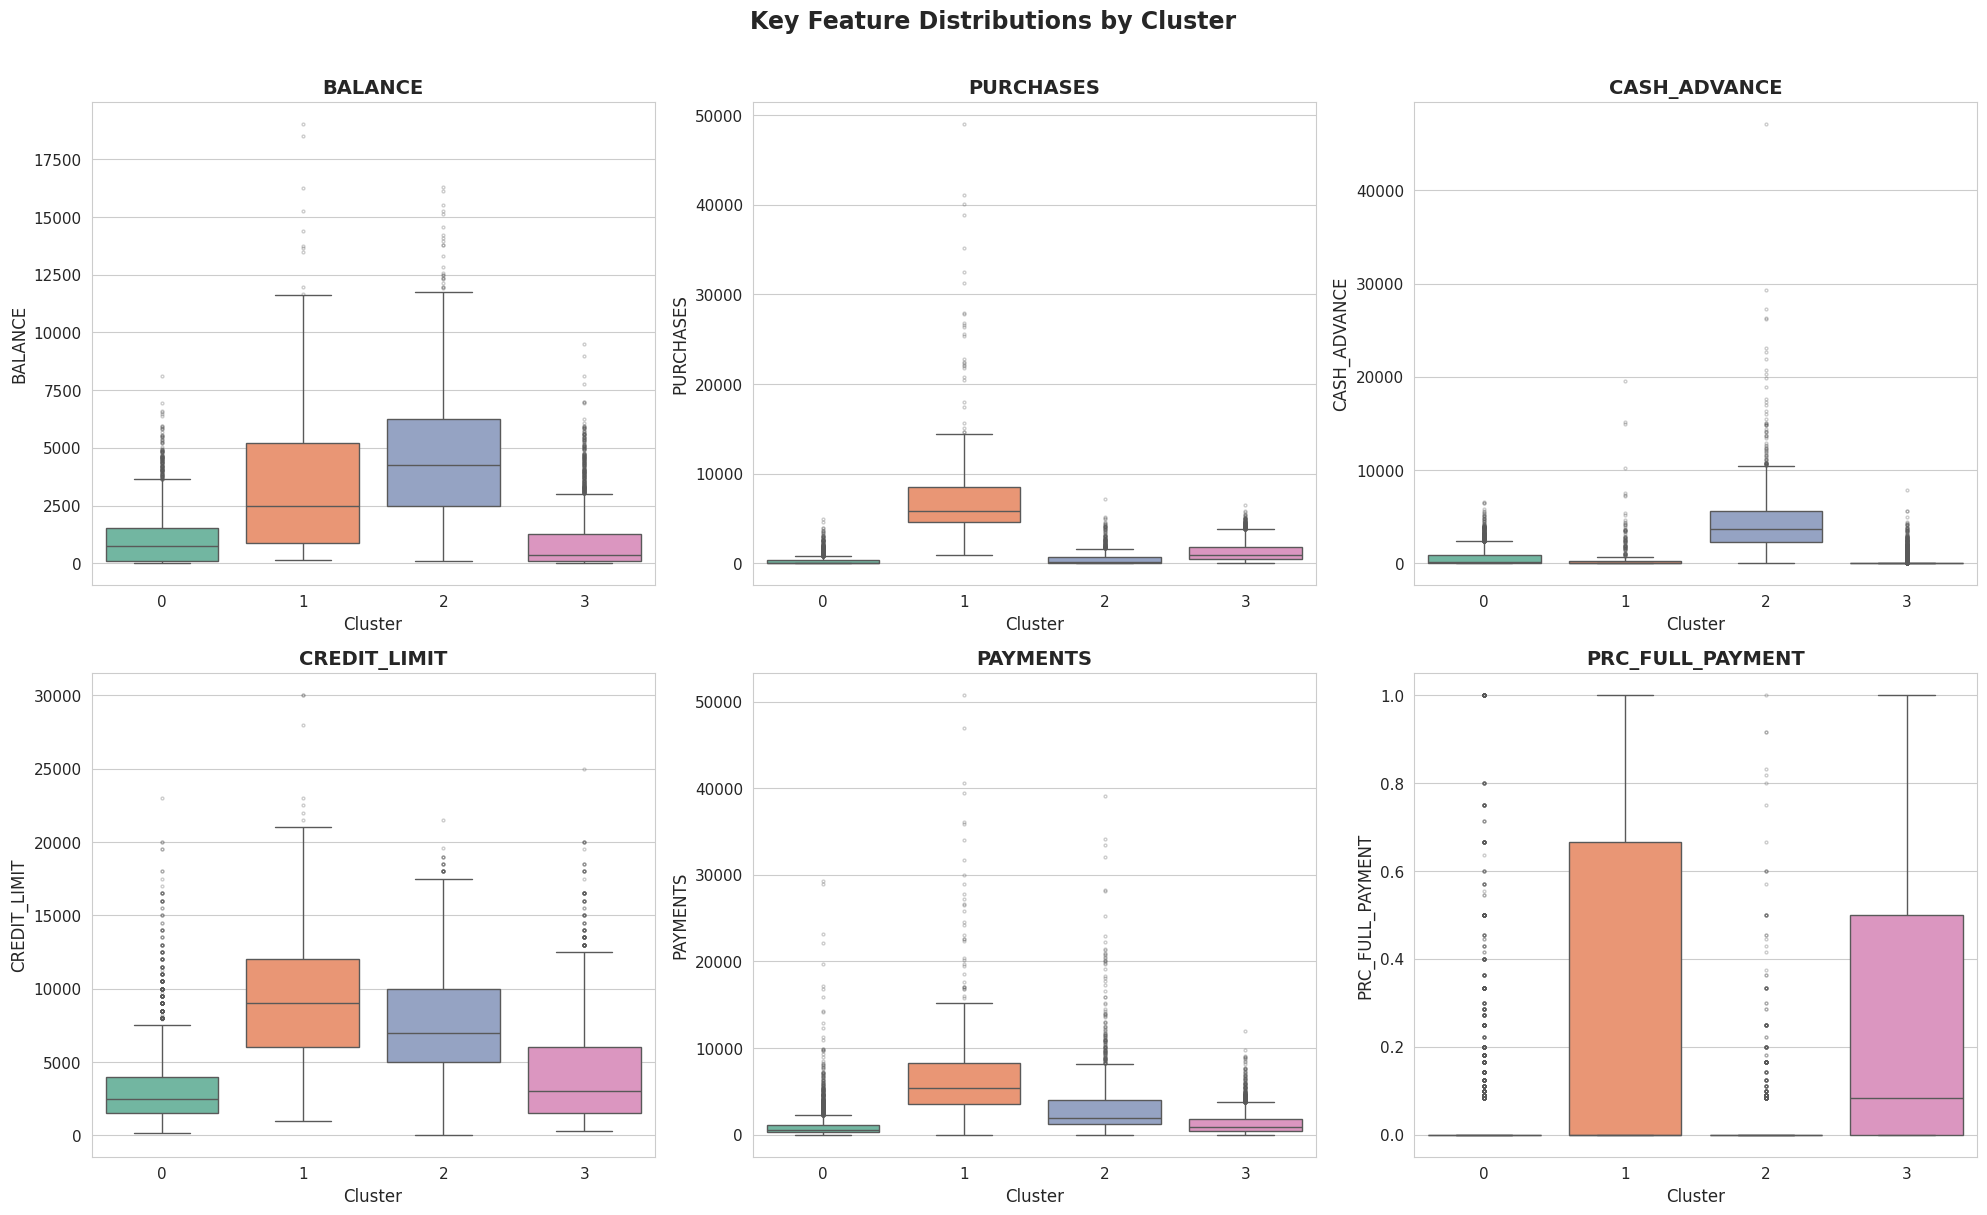

In [21]:
# Box plots for key features by cluster
key_cols = ["BALANCE", "PURCHASES", "CASH_ADVANCE", "CREDIT_LIMIT", "PAYMENTS", "PRC_FULL_PAYMENT"]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for ax, col in zip(axes.flatten(), key_cols):
    sns.boxplot(x="Cluster", y=col, data=df, palette=palette, ax=ax,
                flierprops=dict(marker="o", markersize=2, alpha=0.3))
    ax.set_title(col, fontweight="bold")
fig.suptitle("Key Feature Distributions by Cluster", fontsize=17, fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

### 🧬 Cluster Interpretation

The exact interpretation depends on the cluster means above. Here is a **general framework** — update descriptions after examining the profile table and radar chart:

| Cluster | Persona | Key Characteristics |
|---------|---------|---------------------|
| 0 | **Low-Activity / Dormant** | Low balance, low purchases, low cash advance — possibly inactive cards |
| 1 | **Revolving Borrowers** | High balance, heavy cash-advance usage, pay minimum only |
| 2 | **Active Purchasers** | High purchase volume (one-off & installment), low cash advance, moderate payments |
| 3 | **Premium / VIP** | High credit limit, high purchases, high payments — responsible high-spenders |

> ⚠️ *Update this table after inspecting the actual cluster means & radar chart.*

## 8 · Business Insights & Strategic Recommendations

### Segment-Specific Strategies

| Segment | Strategy |
|---------|----------|
| **Low-Activity / Dormant** | Re-engagement campaigns: cashback offers, lower interest rates, or activation bonuses to increase card usage. |
| **Revolving Borrowers** | Risk monitoring: track default probability; offer balance-transfer plans or structured repayment options to reduce churn and credit risk. |
| **Active Purchasers** | Loyalty & rewards: offer purchase-based reward points, partner discounts, and instalment plans for big-ticket items to deepen engagement. |
| **Premium / VIP** | Retention & upsell: provide concierge services, travel perks, and premium card upgrades. These high-value customers deserve personalised attention. |

### Cross-Cutting Recommendations
1. **Personalised Communication** — Tailor emails, push notifications, and offers to each segment rather than sending blanket campaigns.
2. **Credit-Limit Optimisation** — Use cluster profiles to set dynamic credit limits that balance revenue growth with risk appetite.
3. **Product Design** — Design new card products targeting under-served combinations (e.g., a cash-advance–friendly card for Revolving Borrowers with a lower APR).
4. **Churn Prediction** — Augment clustering with supervised models (e.g., logistic regression) to predict which Dormant or Revolving customers are likely to churn.
5. **Periodic Re-Segmentation** — Re-run clustering quarterly or semi-annually to capture behavioural drift and emerging customer segments.

---
### ✅ Summary

| Phase | Status |
|-------|--------|
| Data Exploration | ✅ Completed |
| Data Cleaning | ✅ Completed |
| Distribution Analysis | ✅ Completed |
| Optimal Cluster Selection | ✅ Completed |
| K-Means Segmentation | ✅ Completed |
| Cluster Profiling | ✅ Completed |
| Business Recommendations | ✅ Completed |

> **Next steps:** Validate segments with domain experts, A/B-test marketing strategies per cluster, and integrate into the CRM pipeline.

#### What to Read — t-SNE

**How it works**: t-SNE preserves **local neighbourhoods** — customers who are similar in the original 17 dimensions stay close together in 2D.

**What to look for**:
- **Tight, well-separated blobs** — each blob represents customers that are similar to each other
- **Number of visible blobs** may suggest the natural number of clusters in the data
- If blobs have **sub-structure** (smaller clusters within a larger one), there may be finer segments worth exploring

**Important caveats**:
- The **distances between blobs are meaningless** — two blobs far apart are not necessarily more different than two close blobs
- The **sizes of blobs are meaningless** — a big blob does not mean more customers; t-SNE expands dense regions
- Only trust **which points are grouped together**, nothing else

#### What to Read — UMAP

**How it works**: UMAP builds a graph of nearest neighbours in high-D and optimises a 2D layout that preserves both **local** (nearby points) and **global** (overall arrangement) structure.

**What to look for**:
- **Distinct, separated blobs** — each blob is a potential natural cluster of customers
- **Relative position of blobs matters** (unlike t-SNE) — blobs that are close are genuinely more similar in the original 17D space
- **Thin bridges** between blobs suggest gradual transitions between customer types (not hard boundaries)
- **Isolated outlier points** far from all blobs are extreme customers

**Key difference from t-SNE**: Faster, and the distances **between** clusters are meaningful — if two blobs are far apart, those customer groups are genuinely different.

#### What to Read — PCA → UMAP (Hybrid)

**How it works**: First, PCA reduces the 17 features down to 10 principal components (removing noise dimensions), then UMAP projects those 10 components into 2D.

**What to look for**:
- **Cleaner clusters** than raw UMAP — PCA pre-filtering removes noisy dimensions that can confuse UMAP
- **Tighter blobs with less scatter** between them indicates the noise reduction worked
- Compare directly with the raw UMAP plot above: if clusters look similar, PCA did not remove useful signal; if they look tighter/cleaner, the extra step helped

**Why it matters**: This is often the **most robust** approach — PCA handles collinearity (which we confirmed in the correlation analysis), and UMAP handles the non-linear structure.

#### Summary — Which Projection to Use?

| Criterion | PCA | t-SNE | UMAP | PCA→UMAP |
|-----------|-----|-------|------|----------|
| Speed | ⚡ Fastest | 🐢 Slowest | ⚡ Fast | ⚡ Fast |
| Cluster separation | ❌ Poor (linear) | ✅ Good (local) | ✅ Good (local+global) | ✅ Best (denoised) |
| Distances meaningful? | ✅ Yes | ❌ No | ✅ Mostly | ✅ Mostly |
| Deterministic? | ✅ Yes | ❌ No | ❌ No | ❌ No |
| Best used for | Quick baseline, variance analysis | Visual exploration | Final visualization | Final visualization |

> **Bottom line**: Look at UMAP or PCA→UMAP to judge how well the clusters separate. If those show clear blobs, k-means or similar will work well. If they show a smooth continuum, consider soft clustering (e.g., GMM).